In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 3

#TRAIN_PATH = '/content/drive/My Drive/UNet/Cell'
#TEST_PATH = '/content/drive/My Drive/UNet/Cell'

# TRAIN_PATH = './Cell/'
# TEST_PATH = './Cell/'

TRAIN_PATH = './new_data/15'
TEST_PATH = './new_data/15'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ['WORLD_SIZE'] = '20'
# os.environ['RANK'] = '0'
# dist.init_process_group(backend='nccl')

#x, y, x_val, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
#split dataset to 80% 10% 10%
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]

# print(x.shape)
# print(y.shape)

########when label is matched delete this#######################
#x = x[:93]
#x_val = x_val[:93]
################################################################
x_train_tensor = torch.from_numpy(x)
y_train_tensor = torch.from_numpy(y)
# x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_train_tensor = x_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_train_tensor = y_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
#print(x_train_tensor.shape)
#print(y_train_tensor.shape)
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
# x_val_tensor = torch.tensor(x_val_tensor, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)
x_val_tensor = x_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_val_tensor = y_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
# val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [4]:
def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

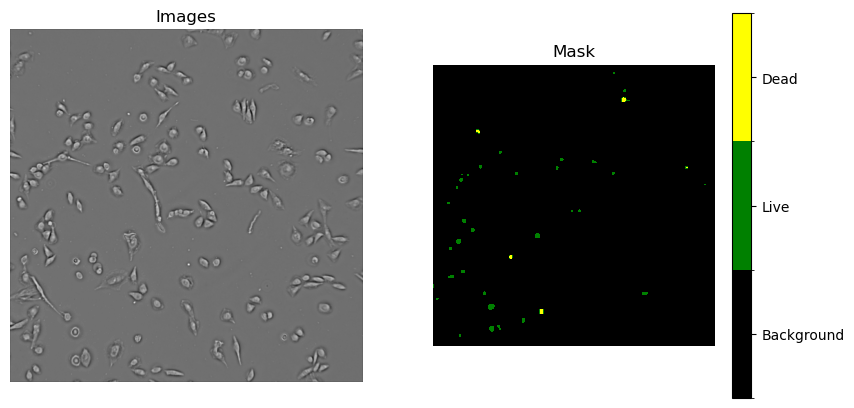

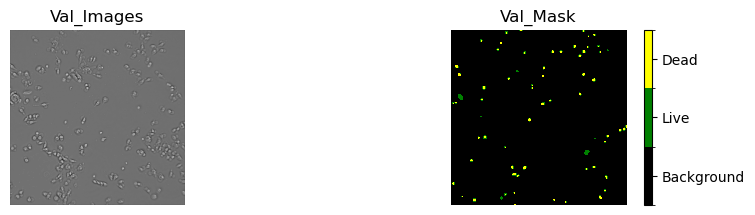

In [5]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[5,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[5],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[5,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[5],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [6]:
# Define IoU metric
import torch

# def mean_iou(y_pred, y_true, num_classes=3):
#     prec = []
    
#     for class_id in range(num_classes):
#         intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
#         union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
#         # Ensure union is not zero
#         union = torch.where(union == 0, torch.ones_like(union), union)
        
#         iou = intersection.float() / union.float()
#         prec.append(iou.item()) 
        
#     return torch.mean(torch.tensor(prec))

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))




In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output

In [8]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [9]:
def jaccard_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    jaccard_loss = 1.0 - (intersection + 1) / (union + 1) 
    return jaccard_loss

In [10]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
#cudnn.benchmark = True
model = torch.nn.DataParallel(model)

class ThreeChannelLogitsLoss(nn.Module):
    def __init__(self):
        super(ThreeChannelLogitsLoss, self).__init__()

    def forward(self, output, target):
        loss = 0
        for i in range(c_out):
            loss += nn.BCEWithLogitsLoss()(output[:, i, :, :], target[:, i, :, :])
        return loss / c_out

#criterion = ThreeChannelLogitsLoss()
#criterion = nn.L1Loss()    
criterion = nn.CrossEntropyLoss()
#criterion = jaccard_loss
#criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [11]:
# #print unet model summary

# from torchsummary import summary

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# #print(model)
# #print(f"Total Trainable Parameters: {count_parameters(model)}")
# summary(model, (3, 128, 128), device= 'cpu')


In [12]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
log_file = open("training_log_new_9.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
print(f'Best loss is {best_loss}, best iou is {best_iou}')


  0%|          | 0/120 [00:00<?, ?it/s]

 42%|████▎     | 51/120 [02:25<02:56,  2.56s/it]

Epoch 1: Batch[50/120] Loss: 0.024607668090611698 IoU: 0.47908495128154754


 83%|████████▎ | 100/120 [04:29<00:51,  2.58s/it]

Epoch 1: Batch[100/120] Loss: 0.020512399319559334 IoU: 0.5172251811623574
Saving model...


100%|██████████| 120/120 [05:23<00:00,  2.70s/it]


Epoch [1/100] Loss: 0.019492753618396818 IoU: 0.5334802972773711
Saving model...


 42%|████▎     | 51/120 [02:03<02:45,  2.40s/it]

Epoch 2: Batch[50/120] Loss: 0.011695538964122534 IoU: 0.7275563859939576


 83%|████████▎ | 100/120 [04:02<00:47,  2.38s/it]

Epoch 2: Batch[100/120] Loss: 0.011252850475721062 IoU: 0.743174124956131
Saving model...


100%|██████████| 120/120 [04:55<00:00,  2.46s/it]


Epoch [2/100] Loss: 0.011049136220632742 IoU: 0.7404702226320903
Saving model...


 42%|████▎     | 51/120 [02:12<02:59,  2.60s/it]

Epoch 3: Batch[50/120] Loss: 0.00837360012345016 IoU: 0.8157503759860992


 83%|████████▎ | 100/120 [04:20<00:49,  2.48s/it]

Epoch 3: Batch[100/120] Loss: 0.008503977213986219 IoU: 0.8100669592618942
Saving model...


100%|██████████| 120/120 [05:12<00:00,  2.60s/it]


Epoch [3/100] Loss: 0.008336563346286614 IoU: 0.8027736773093541
Saving model...


 42%|████▎     | 51/120 [02:12<03:06,  2.70s/it]

Epoch 4: Batch[50/120] Loss: 0.00743247551843524 IoU: 0.8406664931774139


 83%|████████▎ | 100/120 [04:22<00:52,  2.61s/it]

Epoch 4: Batch[100/120] Loss: 0.007389285285025835 IoU: 0.8327805167436599
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [4/100] Loss: 0.007182200402409459 IoU: 0.8256928597887357
Saving model...


 42%|████▎     | 51/120 [02:10<03:02,  2.65s/it]

Epoch 5: Batch[50/120] Loss: 0.006719150738790631 IoU: 0.8576218724250794


 83%|████████▎ | 100/120 [04:17<00:49,  2.50s/it]

Epoch 5: Batch[100/120] Loss: 0.006495154742151499 IoU: 0.8516200602054596
Saving model...


100%|██████████| 120/120 [05:11<00:00,  2.59s/it]


Epoch [5/100] Loss: 0.006399222824256867 IoU: 0.8427331606547038
Saving model...


 42%|████▎     | 51/120 [02:12<02:58,  2.58s/it]

Epoch 6: Batch[50/120] Loss: 0.005844827289693057 IoU: 0.8738269507884979


 83%|████████▎ | 100/120 [04:20<00:51,  2.57s/it]

Epoch 6: Batch[100/120] Loss: 0.005965388484764844 IoU: 0.861661325097084
Saving model...


100%|██████████| 120/120 [05:12<00:00,  2.60s/it]


Epoch [6/100] Loss: 0.005962332017952576 IoU: 0.8525139381488164
Saving model...


 42%|████▎     | 51/120 [02:15<03:05,  2.69s/it]

Epoch 7: Batch[50/120] Loss: 0.0059916584193706515 IoU: 0.87712841629982


 83%|████████▎ | 100/120 [04:23<00:52,  2.61s/it]

Epoch 7: Batch[100/120] Loss: 0.005594292476307601 IoU: 0.8686764520406723
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.65s/it]


Epoch [7/100] Loss: 0.005594177778887873 IoU: 0.8602787812550863
Saving model...


 42%|████▎     | 51/120 [02:12<02:57,  2.57s/it]

Epoch 8: Batch[50/120] Loss: 0.004991801027208567 IoU: 0.8923269879817962


 83%|████████▎ | 100/120 [04:21<00:52,  2.64s/it]

Epoch 8: Batch[100/120] Loss: 0.005198823579121381 IoU: 0.8804890507459641
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [8/100] Loss: 0.005073512743304794 IoU: 0.8709670176108678
Saving model...


 42%|████▎     | 51/120 [02:15<03:03,  2.66s/it]

Epoch 9: Batch[50/120] Loss: 0.004816340366378426 IoU: 0.8985644221305847


 83%|████████▎ | 100/120 [04:23<00:52,  2.63s/it]

Epoch 9: Batch[100/120] Loss: 0.004881954961456358 IoU: 0.8868926256895066
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [9/100] Loss: 0.004890121494342262 IoU: 0.876120558877786
Saving model...


 42%|████▎     | 51/120 [02:17<02:58,  2.59s/it]

Epoch 10: Batch[50/120] Loss: 0.004969117711298167 IoU: 0.8997235488891602


 83%|████████▎ | 100/120 [04:24<00:52,  2.61s/it]

Epoch 10: Batch[100/120] Loss: 0.004864304640796036 IoU: 0.8878952312469482
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.64s/it]


Epoch [10/100] Loss: 0.0047835523941709346 IoU: 0.8786065181096395
Saving model...


 42%|████▎     | 51/120 [02:16<03:01,  2.63s/it]

Epoch 11: Batch[50/120] Loss: 0.00457825178746134 IoU: 0.9067603063583374


 83%|████████▎ | 100/120 [04:24<00:52,  2.60s/it]

Epoch 11: Batch[100/120] Loss: 0.004583543110638857 IoU: 0.8933510875701904
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.64s/it]


Epoch [11/100] Loss: 0.004500962157423297 IoU: 0.8849431475003561
Saving model...


 42%|████▎     | 51/120 [02:12<03:00,  2.61s/it]

Epoch 12: Batch[50/120] Loss: 0.004346768073737621 IoU: 0.9101457512378692


 83%|████████▎ | 100/120 [04:20<00:53,  2.67s/it]

Epoch 12: Batch[100/120] Loss: 0.004269081363454461 IoU: 0.8995534175634384
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.64s/it]


Epoch [12/100] Loss: 0.004301589624568199 IoU: 0.8889193172256152
Saving model...


 42%|████▎     | 51/120 [02:14<02:58,  2.59s/it]

Epoch 13: Batch[50/120] Loss: 0.004447210803627968 IoU: 0.9108638632297515


 83%|████████▎ | 100/120 [04:23<00:53,  2.66s/it]

Epoch 13: Batch[100/120] Loss: 0.004327070894651115 IoU: 0.8985628509521484
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.64s/it]


Epoch [13/100] Loss: 0.004309133572193483 IoU: 0.8892758518457413
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:12<02:57,  2.58s/it]

Epoch 14: Batch[50/120] Loss: 0.004131176727823913 IoU: 0.9159685897827149


 83%|████████▎ | 100/120 [04:19<00:52,  2.64s/it]

Epoch 14: Batch[100/120] Loss: 0.004064620449207723 IoU: 0.9044143468141556
Saving model...


100%|██████████| 120/120 [05:11<00:00,  2.60s/it]


Epoch [14/100] Loss: 0.004119273125737285 IoU: 0.89383138914903
Saving model...


 42%|████▎     | 51/120 [02:13<03:02,  2.65s/it]

Epoch 15: Batch[50/120] Loss: 0.003787141921930015 IoU: 0.9185949182510376


 83%|████████▎ | 100/120 [04:22<00:53,  2.66s/it]

Epoch 15: Batch[100/120] Loss: 0.0039700117590837185 IoU: 0.9066732585430145
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [15/100] Loss: 0.004018549450362722 IoU: 0.8965601906180382
Saving model...


 42%|████▎     | 51/120 [02:14<03:00,  2.61s/it]

Epoch 16: Batch[50/120] Loss: 0.0039043993782252075 IoU: 0.9181838715076447


 83%|████████▎ | 100/120 [04:21<00:52,  2.60s/it]

Epoch 16: Batch[100/120] Loss: 0.0038782022916711866 IoU: 0.9079939645528793
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [16/100] Loss: 0.0038289389204389105 IoU: 0.9008152991533279
Saving model...


 42%|████▎     | 51/120 [02:13<03:00,  2.61s/it]

Epoch 17: Batch[50/120] Loss: 0.00370552153326571 IoU: 0.9239581477642059


 83%|████████▎ | 100/120 [04:25<00:55,  2.75s/it]

Epoch 17: Batch[100/120] Loss: 0.003689301535487175 IoU: 0.9142280751466751
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.67s/it]


Epoch [17/100] Loss: 0.0036597290192730723 IoU: 0.9048849413792293
Saving model...


 42%|████▎     | 51/120 [02:13<02:58,  2.59s/it]

Epoch 18: Batch[50/120] Loss: 0.003600004888139665 IoU: 0.9264266741275787


 83%|████████▎ | 100/120 [04:22<00:52,  2.62s/it]

Epoch 18: Batch[100/120] Loss: 0.003620120396371931 IoU: 0.9150648152828217
Saving model...


100%|██████████| 120/120 [05:15<00:00,  2.63s/it]


Epoch [18/100] Loss: 0.0036180200482097765 IoU: 0.9060772935549418
Saving model...


 42%|████▎     | 51/120 [02:15<03:06,  2.70s/it]

Epoch 19: Batch[50/120] Loss: 0.003410630989819765 IoU: 0.9323745441436767


 83%|████████▎ | 100/120 [04:24<00:53,  2.70s/it]

Epoch 19: Batch[100/120] Loss: 0.003494680863805115 IoU: 0.9208653950691223
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.66s/it]


Epoch [19/100] Loss: 0.0033902635438910994 IoU: 0.9118686293562254
Saving model...


 42%|████▎     | 51/120 [02:15<02:56,  2.55s/it]

Epoch 20: Batch[50/120] Loss: 0.0036481602117419245 IoU: 0.9310349631309509


 83%|████████▎ | 100/120 [04:24<00:52,  2.63s/it]

Epoch 20: Batch[100/120] Loss: 0.0033642818545922635 IoU: 0.9231327509880066
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [20/100] Loss: 0.003328316604408125 IoU: 0.9136621842781703
Saving model...


 42%|████▎     | 51/120 [02:17<03:01,  2.63s/it]

Epoch 21: Batch[50/120] Loss: 0.0031344034662470223 IoU: 0.9381259226799011


 83%|████████▎ | 100/120 [04:27<00:52,  2.64s/it]

Epoch 21: Batch[100/120] Loss: 0.003165605899412185 IoU: 0.9269631177186965
Saving model...


100%|██████████| 120/120 [05:20<00:00,  2.67s/it]


Epoch [21/100] Loss: 0.0031713634030893444 IoU: 0.9165700450539589
Saving model...


 42%|████▎     | 51/120 [02:13<03:02,  2.65s/it]

Epoch 22: Batch[50/120] Loss: 0.0030039165006019177 IoU: 0.9392176687717437


 83%|████████▎ | 100/120 [04:25<00:56,  2.83s/it]

Epoch 22: Batch[100/120] Loss: 0.003110046604415402 IoU: 0.9282852554321289
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [22/100] Loss: 0.0031144957814831288 IoU: 0.9191772560278575
Saving model...


 42%|████▎     | 51/120 [02:12<03:01,  2.63s/it]

Epoch 23: Batch[50/120] Loss: 0.002845863930415362 IoU: 0.9425443124771118


 83%|████████▎ | 100/120 [04:21<00:52,  2.65s/it]

Epoch 23: Batch[100/120] Loss: 0.0029869194130878896 IoU: 0.9315011495351792
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [23/100] Loss: 0.0030388793122256173 IoU: 0.9206432263056438
Saving model...


 42%|████▎     | 51/120 [02:13<02:59,  2.60s/it]

Epoch 24: Batch[50/120] Loss: 0.0029625143390148876 IoU: 0.941648770570755


 83%|████████▎ | 100/120 [04:22<00:51,  2.57s/it]

Epoch 24: Batch[100/120] Loss: 0.002906978274695575 IoU: 0.93298042178154
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.63s/it]


Epoch [24/100] Loss: 0.0029479544124721238 IoU: 0.9227994466821353
Saving model...


 42%|████▎     | 51/120 [02:15<03:13,  2.80s/it]

Epoch 25: Batch[50/120] Loss: 0.0029688997170887886 IoU: 0.9443372368812561


 83%|████████▎ | 100/120 [04:28<00:52,  2.61s/it]

Epoch 25: Batch[100/120] Loss: 0.0028388440806884317 IoU: 0.9362524610757827
Saving model...


100%|██████████| 120/120 [05:21<00:00,  2.68s/it]


Epoch [25/100] Loss: 0.002817206301066714 IoU: 0.9267996648947397
Saving model...


 42%|████▎     | 51/120 [02:14<03:01,  2.63s/it]

Epoch 26: Batch[50/120] Loss: 0.002966421116143465 IoU: 0.9416922450065612


 83%|████████▎ | 100/120 [04:25<00:53,  2.66s/it]

Epoch 26: Batch[100/120] Loss: 0.002939710763748735 IoU: 0.9325857323408127
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [26/100] Loss: 0.002903844251219804 IoU: 0.9238197540243467
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:13<02:59,  2.61s/it]

Epoch 27: Batch[50/120] Loss: 0.0027364982781000434 IoU: 0.9469255447387696


 83%|████████▎ | 100/120 [04:22<00:53,  2.65s/it]

Epoch 27: Batch[100/120] Loss: 0.0028432511060964318 IoU: 0.936334746479988
Saving model...


100%|██████████| 120/120 [05:15<00:00,  2.63s/it]


Epoch [27/100] Loss: 0.0027871024057579538 IoU: 0.9264744311571121
Saving model...


 42%|████▎     | 51/120 [02:14<03:01,  2.63s/it]

Epoch 28: Batch[50/120] Loss: 0.0030028158659115432 IoU: 0.9414007270336151


 83%|████████▎ | 100/120 [04:22<00:52,  2.61s/it]

Epoch 28: Batch[100/120] Loss: 0.002826792889973149 IoU: 0.9362105745077133
Saving model...


100%|██████████| 120/120 [05:15<00:00,  2.63s/it]


Epoch [28/100] Loss: 0.0027624621773914746 IoU: 0.927182079354922
Saving model...


 42%|████▎     | 51/120 [02:11<02:59,  2.60s/it]

Epoch 29: Batch[50/120] Loss: 0.0027864199760369956 IoU: 0.9449226951599121


 83%|████████▎ | 100/120 [04:20<00:53,  2.65s/it]

Epoch 29: Batch[100/120] Loss: 0.0028695191093720497 IoU: 0.9349890291690827
Saving model...


100%|██████████| 120/120 [05:14<00:00,  2.62s/it]


Epoch [29/100] Loss: 0.0028138527345921223 IoU: 0.9265500927964846
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<02:59,  2.61s/it]

Epoch 30: Batch[50/120] Loss: 0.0025810682983137666 IoU: 0.9530598735809326


 83%|████████▎ | 100/120 [04:24<00:53,  2.67s/it]

Epoch 30: Batch[100/120] Loss: 0.002599020474590361 IoU: 0.9415250813961029
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.64s/it]


Epoch [30/100] Loss: 0.00255631972104311 IoU: 0.9325752298037211
Saving model...


 42%|████▎     | 51/120 [02:12<02:48,  2.44s/it]

Epoch 31: Batch[50/120] Loss: 0.0023836430092342197 IoU: 0.9566566228866578


 83%|████████▎ | 100/120 [04:20<00:54,  2.73s/it]

Epoch 31: Batch[100/120] Loss: 0.0023817671532742678 IoU: 0.9473900759220123
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.63s/it]


Epoch [31/100] Loss: 0.002386482509124714 IoU: 0.9371678863962492
Saving model...


 42%|████▎     | 51/120 [02:18<03:06,  2.70s/it]

Epoch 32: Batch[50/120] Loss: 0.0025913357199169695 IoU: 0.9522324216365814


 83%|████████▎ | 100/120 [04:25<00:49,  2.49s/it]

Epoch 32: Batch[100/120] Loss: 0.0025024732400197535 IoU: 0.9442106026411057
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [32/100] Loss: 0.002468792446112881 IoU: 0.9352901791532834
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<03:02,  2.65s/it]

Epoch 33: Batch[50/120] Loss: 0.002211353674065322 IoU: 0.958722529411316


 83%|████████▎ | 100/120 [04:24<00:53,  2.66s/it]

Epoch 33: Batch[100/120] Loss: 0.002268255993258208 IoU: 0.9489031380414963
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [33/100] Loss: 0.0023064337166336674 IoU: 0.9391171966989835
Saving model...


 42%|████▎     | 51/120 [02:15<03:01,  2.64s/it]

Epoch 34: Batch[50/120] Loss: 0.00221712565748021 IoU: 0.9605036211013794


 83%|████████▎ | 100/120 [04:26<00:53,  2.68s/it]

Epoch 34: Batch[100/120] Loss: 0.0023186354793142527 IoU: 0.9493639266490936
Saving model...


100%|██████████| 120/120 [05:20<00:00,  2.67s/it]


Epoch [34/100] Loss: 0.0023070587378848967 IoU: 0.9392613063255946
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:15<03:02,  2.65s/it]

Epoch 35: Batch[50/120] Loss: 0.002238546242006123 IoU: 0.9600191688537598


 83%|████████▎ | 100/120 [04:25<00:53,  2.67s/it]

Epoch 35: Batch[100/120] Loss: 0.002311333396937698 IoU: 0.948782821893692
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [35/100] Loss: 0.002305802725216684 IoU: 0.93906755844752
Saving model...


 42%|████▎     | 51/120 [02:19<03:11,  2.78s/it]

Epoch 36: Batch[50/120] Loss: 0.0024082519300282 IoU: 0.9558825814723968


 83%|████████▎ | 100/120 [04:32<00:56,  2.83s/it]

Epoch 36: Batch[100/120] Loss: 0.002392286044778302 IoU: 0.9467300671339035
Saving model...


100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


Epoch [36/100] Loss: 0.0023543770735462506 IoU: 0.9381538227200508
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<03:01,  2.63s/it]

Epoch 37: Batch[50/120] Loss: 0.002080214819870889 IoU: 0.9652599680423737


 83%|████████▎ | 100/120 [04:23<00:53,  2.66s/it]

Epoch 37: Batch[100/120] Loss: 0.0021500373363960534 IoU: 0.9532164442539215
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [37/100] Loss: 0.0021782384108519183 IoU: 0.9427000557382902
Saving model...


 42%|████▎     | 51/120 [02:21<03:03,  2.67s/it]

Epoch 38: Batch[50/120] Loss: 0.0022154088248498736 IoU: 0.9616754400730133


 83%|████████▎ | 100/120 [04:29<00:51,  2.60s/it]

Epoch 38: Batch[100/120] Loss: 0.002213634861400351 IoU: 0.952206164598465
Saving model...


100%|██████████| 120/120 [05:22<00:00,  2.69s/it]


Epoch [38/100] Loss: 0.00220973977605657 IoU: 0.9423045843839646
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<03:00,  2.62s/it]

Epoch 39: Batch[50/120] Loss: 0.00217166195390746 IoU: 0.9638078236579894


 83%|████████▎ | 100/120 [04:24<00:52,  2.64s/it]

Epoch 39: Batch[100/120] Loss: 0.002151658145012334 IoU: 0.9535456019639968
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.65s/it]


Epoch [39/100] Loss: 0.0021361308434279637 IoU: 0.9438727920254072
Saving model...


 42%|████▎     | 51/120 [02:15<03:07,  2.72s/it]

Epoch 40: Batch[50/120] Loss: 0.002300342118833214 IoU: 0.9604305481910705


 83%|████████▎ | 100/120 [04:27<00:53,  2.69s/it]

Epoch 40: Batch[100/120] Loss: 0.0022555171290878206 IoU: 0.9506206732988357
Saving model...


100%|██████████| 120/120 [05:21<00:00,  2.68s/it]


Epoch [40/100] Loss: 0.0021999392348031202 IoU: 0.9418459162116051
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<03:01,  2.63s/it]

Epoch 41: Batch[50/120] Loss: 0.0019924345007166265 IoU: 0.9657299935817718


 83%|████████▎ | 100/120 [04:23<00:53,  2.66s/it]

Epoch 41: Batch[100/120] Loss: 0.002141201738268137 IoU: 0.9527748441696167
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.65s/it]


Epoch [41/100] Loss: 0.0021391624458677446 IoU: 0.9435109222928683
EarlyStopping counter: 2 out of 5


 42%|████▎     | 51/120 [02:22<03:12,  2.78s/it]

Epoch 42: Batch[50/120] Loss: 0.002038404741324484 IoU: 0.9679123163223267


 83%|████████▎ | 100/120 [04:32<00:52,  2.62s/it]

Epoch 42: Batch[100/120] Loss: 0.0020270787074696275 IoU: 0.9569757896661758
Saving model...


100%|██████████| 120/120 [05:25<00:00,  2.71s/it]


Epoch [42/100] Loss: 0.002020289917709306 IoU: 0.9468769575158755
Saving model...


 42%|████▎     | 51/120 [02:15<03:01,  2.62s/it]

Epoch 43: Batch[50/120] Loss: 0.0022143784700892864 IoU: 0.9634955155849457


 83%|████████▎ | 100/120 [04:24<00:52,  2.62s/it]

Epoch 43: Batch[100/120] Loss: 0.0021810316119808704 IoU: 0.9536281424760819
Saving model...


100%|██████████| 120/120 [05:17<00:00,  2.65s/it]


Epoch [43/100] Loss: 0.002158563064100842 IoU: 0.94362736394008
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:14<03:02,  2.64s/it]

Epoch 44: Batch[50/120] Loss: 0.002011811463162303 IoU: 0.9705978167057038


 83%|████████▎ | 100/120 [04:25<00:54,  2.72s/it]

Epoch 44: Batch[100/120] Loss: 0.00199463346041739 IoU: 0.9583174633979797
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [44/100] Loss: 0.0019514804055991892 IoU: 0.9490669220685959
Saving model...


 42%|████▎     | 51/120 [02:14<03:02,  2.65s/it]

Epoch 45: Batch[50/120] Loss: 0.001888013870920986 IoU: 0.9706891536712646


 83%|████████▎ | 100/120 [04:24<00:53,  2.66s/it]

Epoch 45: Batch[100/120] Loss: 0.001918409465579316 IoU: 0.9592824298143386
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [45/100] Loss: 0.0019247953799397994 IoU: 0.9496526703238487
Saving model...


 42%|████▎     | 51/120 [02:14<03:06,  2.71s/it]

Epoch 46: Batch[50/120] Loss: 0.0018529891432262956 IoU: 0.9731932687759399


 83%|████████▎ | 100/120 [04:26<00:54,  2.70s/it]

Epoch 46: Batch[100/120] Loss: 0.0018486155412392692 IoU: 0.9616668421030045
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.66s/it]


Epoch [46/100] Loss: 0.001838436970623055 IoU: 0.951700110733509
Saving model...


 42%|████▎     | 51/120 [02:13<02:58,  2.59s/it]

Epoch 47: Batch[50/120] Loss: 0.001849711190443486 IoU: 0.9721749126911163


 83%|████████▎ | 100/120 [04:23<00:53,  2.66s/it]

Epoch 47: Batch[100/120] Loss: 0.001868645415524952 IoU: 0.9622623312473297
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.64s/it]


Epoch [47/100] Loss: 0.0018190043672802858 IoU: 0.9526533648371697
Saving model...


 42%|████▎     | 51/120 [02:14<03:02,  2.64s/it]

Epoch 48: Batch[50/120] Loss: 0.0017562322225421667 IoU: 0.9725549113750458


 83%|████████▎ | 100/120 [04:23<00:52,  2.64s/it]

Epoch 48: Batch[100/120] Loss: 0.0018044257839210332 IoU: 0.9617804396152496
Saving model...


100%|██████████| 120/120 [05:16<00:00,  2.64s/it]


Epoch [48/100] Loss: 0.0017969076284013378 IoU: 0.9524074355761211
Saving model...


 42%|████▎     | 51/120 [02:15<03:02,  2.64s/it]

Epoch 49: Batch[50/120] Loss: 0.0017096307303290815 IoU: 0.9743478012084961


 83%|████████▎ | 100/120 [04:24<00:54,  2.74s/it]

Epoch 49: Batch[100/120] Loss: 0.0017674348450964317 IoU: 0.9640247511863709
Saving model...


100%|██████████| 120/120 [05:21<00:00,  2.68s/it]


Epoch [49/100] Loss: 0.0017409396158958165 IoU: 0.9544554601113001
Saving model...


 42%|████▎     | 51/120 [02:16<03:03,  2.66s/it]

Epoch 50: Batch[50/120] Loss: 0.0017640221409965307 IoU: 0.974610561132431


 83%|████████▎ | 100/120 [04:26<00:53,  2.65s/it]

Epoch 50: Batch[100/120] Loss: 0.001831587715423666 IoU: 0.9623251116275787
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.66s/it]


Epoch [50/100] Loss: 0.0018100631952014132 IoU: 0.9525682290395101
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:15<03:07,  2.72s/it]

Epoch 51: Batch[50/120] Loss: 0.0018602450867183506 IoU: 0.9711588776111603


 83%|████████▎ | 100/120 [04:28<00:55,  2.77s/it]

Epoch 51: Batch[100/120] Loss: 0.0019893220742233098 IoU: 0.9582419055700302
Saving model...


100%|██████████| 120/120 [05:22<00:00,  2.69s/it]


Epoch [51/100] Loss: 0.001933021383592859 IoU: 0.9491558546821276
EarlyStopping counter: 2 out of 5


 42%|████▎     | 51/120 [02:15<03:02,  2.64s/it]

Epoch 52: Batch[50/120] Loss: 0.0015758169337641448 IoU: 0.9772147405147552


 83%|████████▎ | 100/120 [04:24<00:52,  2.64s/it]

Epoch 52: Batch[100/120] Loss: 0.0017119787394767627 IoU: 0.9663389486074447
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [52/100] Loss: 0.001688568603033976 IoU: 0.9565655673543613
Saving model...


 42%|████▎     | 51/120 [02:13<03:04,  2.67s/it]

Epoch 53: Batch[50/120] Loss: 0.0016000495897606016 IoU: 0.9786424541473389


 83%|████████▎ | 100/120 [04:26<00:53,  2.66s/it]

Epoch 53: Batch[100/120] Loss: 0.001601691884570755 IoU: 0.9679024976491928
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.67s/it]


Epoch [53/100] Loss: 0.0015918398222614391 IoU: 0.9582649355133375
Saving model...


 42%|████▎     | 51/120 [02:18<03:10,  2.75s/it]

Epoch 54: Batch[50/120] Loss: 0.0016578264359850437 IoU: 0.9780461883544922


 83%|████████▎ | 100/120 [04:33<00:56,  2.80s/it]

Epoch 54: Batch[100/120] Loss: 0.001579971078899689 IoU: 0.9685958600044251
Saving model...


100%|██████████| 120/120 [05:28<00:00,  2.74s/it]


Epoch [54/100] Loss: 0.0015779378052684478 IoU: 0.9586404075225194
Saving model...


 42%|████▎     | 51/120 [02:16<03:00,  2.62s/it]

Epoch 55: Batch[50/120] Loss: 0.001652318985434249 IoU: 0.9782730650901794


 83%|████████▎ | 100/120 [04:27<00:53,  2.69s/it]

Epoch 55: Batch[100/120] Loss: 0.0015658804378472268 IoU: 0.9696100425720214
Saving model...


100%|██████████| 120/120 [05:20<00:00,  2.67s/it]


Epoch [55/100] Loss: 0.0015673983701465961 IoU: 0.9596125647425652
Saving model...


 42%|████▎     | 51/120 [02:15<02:59,  2.61s/it]

Epoch 56: Batch[50/120] Loss: 0.0016519170813262462 IoU: 0.9771455419063568


 83%|████████▎ | 100/120 [04:24<00:53,  2.65s/it]

Epoch 56: Batch[100/120] Loss: 0.0016429312701802701 IoU: 0.9674067336320877
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.65s/it]


Epoch [56/100] Loss: 0.0016226030740654096 IoU: 0.9580320780475934
EarlyStopping counter: 1 out of 5


 42%|████▎     | 51/120 [02:16<03:04,  2.67s/it]

Epoch 57: Batch[50/120] Loss: 0.0016783018223941327 IoU: 0.9764050781726837


 83%|████████▎ | 100/120 [04:25<00:52,  2.64s/it]

Epoch 57: Batch[100/120] Loss: 0.0017049653298454358 IoU: 0.9660975402593612
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.66s/it]


Epoch [57/100] Loss: 0.0017038611176152093 IoU: 0.9557757645845413
EarlyStopping counter: 2 out of 5


 42%|████▎     | 51/120 [02:15<03:04,  2.68s/it]

Epoch 58: Batch[50/120] Loss: 0.0016753005783539266 IoU: 0.9776151061058045


 83%|████████▎ | 100/120 [04:25<00:52,  2.62s/it]

Epoch 58: Batch[100/120] Loss: 0.0016567985666915775 IoU: 0.9671780991554261
Saving model...


100%|██████████| 120/120 [05:18<00:00,  2.66s/it]


Epoch [58/100] Loss: 0.0016615622963096635 IoU: 0.9569864084323247
EarlyStopping counter: 3 out of 5


 42%|████▎     | 51/120 [02:15<03:07,  2.71s/it]

Epoch 59: Batch[50/120] Loss: 0.0019173500395845621 IoU: 0.9722748053073883


 83%|████████▎ | 100/120 [04:25<00:54,  2.70s/it]

Epoch 59: Batch[100/120] Loss: 0.0019430576398735866 IoU: 0.9604496371746063
Saving model...


100%|██████████| 120/120 [05:19<00:00,  2.66s/it]


Epoch [59/100] Loss: 0.0018726616666147795 IoU: 0.9515437468886375
EarlyStopping counter: 4 out of 5


 42%|████▎     | 51/120 [02:19<03:00,  2.61s/it]

Epoch 60: Batch[50/120] Loss: 0.001722319700056687 IoU: 0.9751288187503815


 83%|████████▎ | 100/120 [04:29<00:53,  2.69s/it]

Epoch 60: Batch[100/120] Loss: 0.0016359902074327692 IoU: 0.9675655925273895
Saving model...


100%|██████████| 120/120 [05:22<00:00,  2.69s/it]

Epoch [60/100] Loss: 0.0015991307601022223 IoU: 0.9584351549545924
EarlyStopping counter: 5 out of 5
Early stopping triggered
Best loss is 0.0015673983701465961, best iou is 0.9596125647425652


In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_val_loader_predictions(model, data_loader, device, class_colors):
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs = inputs.permute(0, 3, 1, 2).to(device)
#             labels = labels.squeeze(1).to(device)

#             print(f'Inputs shape: {inputs.shape}')
#             print(f'Labels shape: {labels.shape}')
#             print(f'Labels unique values: {np.unique(labels.cpu().numpy())}')

#             outputs = model(inputs)
#             print(f'Model outputs before argmax: {outputs.shape}, min: {outputs.min().item()}, max: {outputs.max().item()}')

#             predicted = torch.argmax(outputs, dim=1).cpu().numpy()
#             true_labels = labels.cpu().numpy()

#             print(f'Model predicted after argmax: {np.unique(predicted)}')
#             print(f'True labels unique values: {np.unique(true_labels)}')

#             for i in range(len(predicted)):
#                 segmented_image = predicted[i]
#                 true_label = true_labels[i]
#                 height, width = segmented_image.shape

#                 color_image_pred = np.zeros((height, width, 3), dtype=np.uint8)
#                 for cls, color in class_colors.items():
#                     mask = segmented_image == cls
#                     color_image_pred[mask] = color

#                 color_image_label = np.zeros((height, width, 3), dtype=np.uint8)
#                 for cls, color in class_colors.items():
#                     mask = true_label == cls
#                     if mask.shape == (height, width):
#                         color_image_label[mask] = color

#                 plt.figure(figsize=(15, 5))

#                 plt.subplot(1, 2, 1)
#                 plt.imshow(color_image_pred)
#                 plt.title("Predicted Output")
#                 plt.axis("off")

#                 plt.subplot(1, 2, 2)
#                 plt.imshow(color_image_label)
#                 plt.title("Ground Truth")
#                 plt.axis("off")

#                 plt.tight_layout()
#                 plt.show()
#                 return

# class_colors = {
#     0: [0, 0, 0],
#     1: [0, 255, 0],
#     2: [255, 255, 0],
# }

# model.to(device1)
# visualize_val_loader_predictions(model, val_loader, device1, class_colors)



In [14]:
model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

Validation Loss: 0.014273776300251484, Validation IoU: 0.819423770904541


In [15]:
model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


In [16]:
def transform(preds):
    
    preds_val_transformed = []
    
    for pre in preds:
        preds_argmax = torch.argmax(pre, dim=1)
        preds_val_transformed.append(preds_argmax)
        
    preds = torch.cat(preds_val_transformed, dim=0)
    
    return preds

preds_val_t = transform(preds_val)
preds_test_t = transform(preds_test)

In [17]:
#print(preds_val.shape)

In [18]:
# preds_val_t = []
# preds_test_t = []

# # def transform_value(value):
# #     if value < 1:
# #         return 0
# #     elif value < 2:
# #         return 1
# #     else:
# #         return 2

# def threshold(preds,preds_t):
#     for pre in preds:
        
#         transformed_preds_test = torch.where(pre < 1, torch.tensor(0, device=device1), 
#                                              torch.where(pre < 2, torch.tensor(1, device=device1), torch.tensor(2, device=device1)))

#         max_preds_test = torch.argmax(transformed_preds_test, dim=0)
        
#         # max_preds_test = torch.max(pre, dim=0).values
        
#         preds_t.append(max_preds_test.unsqueeze(0))
        
#     return preds_t

# preds_val_t = threshold(preds_val, preds_val_t)
# preds_test_t = threshold(preds_test, preds_test_t)
        


In [19]:
print(preds_val_t.shape)
for pre in preds_val_t:
    if pre.any() == 2:
        print(True)

torch.Size([75, 512, 512])


In [20]:
# import random
# import matplotlib.pyplot as plt

# X_test = torch.Tensor(X_test).permute(0, 2, 3, 1)


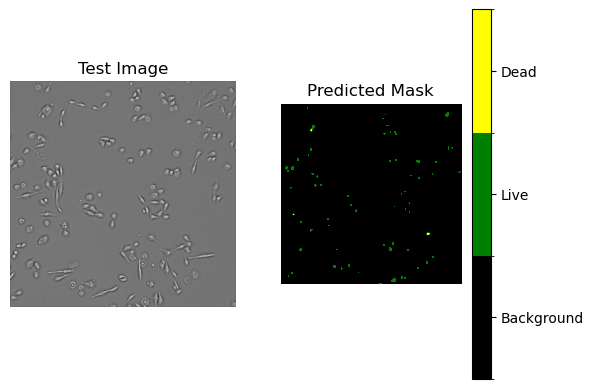

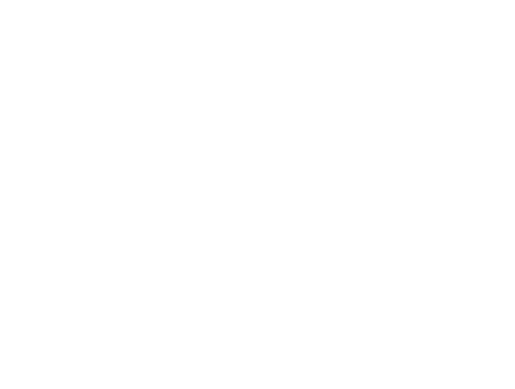

In [21]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0]
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

#predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()


In [22]:
for i in range(len(preds_test_t)):
    predicted_mask = preds_test_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    mask_name = os.path.join('./new_train/15/test', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./new_train/15/test', f'image_{i}.jpg')

    plt.savefig(mask_name) 
    plt.close()  

    plt.imshow(X_test[i,:, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)  
    plt.close() 

In [23]:
# for i in range(4):
#     predicted_mask = preds_test_t[i].cpu().numpy()
#     predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
#     mask1 = predicted_mask[..., 0]  # Assuming the first mask is at index 0
#     mask2 = predicted_mask[..., 1]  # Assuming the second mask is at index 1
#     if mask2.any()>0:
#         print(True)
#     # plt.subplot(i+1, 2, 1)
#     # plt.imshow(mask1,cmap='gray')
#     # plt.subplot(i+1, 2, 2)
#     # plt.imshow(mask2,cmap='gray')

In [24]:
'''
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_train_cpu = x
Y_train_cpu = y

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow_tensor(X_train_cpu[ix])
imshow_tensor(Y_train_cpu[ix])
imshow_tensor(preds_train_t[ix].cpu())
'''


"\nimport random\nimport torch\nimport matplotlib.pyplot as plt\n\n# Define a function to display images\ndef imshow_tensor(tensor):\n    # Ensure the tensor is on the CPU and convert it to a NumPy array\n    #tensor = tensor.cpu().numpy()\n\n    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)\n    if len(tensor.shape) == 3 and tensor.shape[0] == 1:\n        tensor = tensor.squeeze(0)\n\n    # Display the image\n    plt.imshow(tensor, cmap='gray')\n    plt.show()\n\n# Move your tensors to CPU (if they are not already)\nX_train_cpu = x\nY_train_cpu = y\n\n# Perform a sanity check on some random training samples\nix = random.randint(0, len(preds_train_t))\nimshow_tensor(X_train_cpu[ix])\nimshow_tensor(Y_train_cpu[ix])\nimshow_tensor(preds_train_t[ix].cpu())\n"

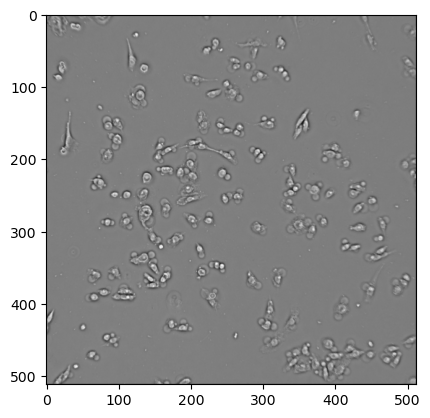

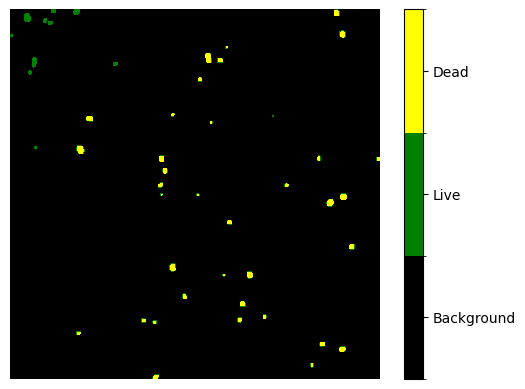

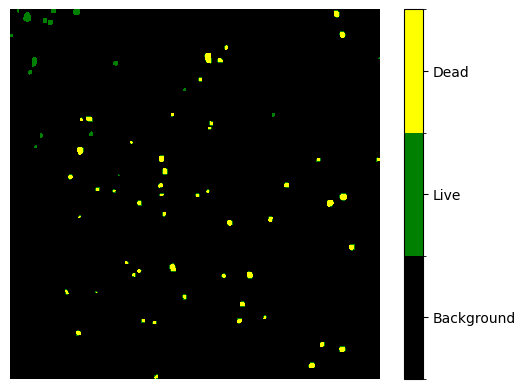

In [25]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
#predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

In [26]:
import cv2

for i in range(len(preds_val_t)):
    predicted_mask = preds_val_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    
    ground_show = Y_val_cpu[i,:,:,0]

    mask_name = os.path.join('./new_train/15/val', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./new_train/15/val', f'image_{i}.jpg')
    ground_name = os.path.join('./new_train/15/val', f'ground_truth_{i}.jpg')

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    plt.savefig(mask_name)
    plt.close()

    plt.imshow(X_val_cpu[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)
    plt.close()

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(ground_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    plt.savefig(ground_name)
    plt.close()


In [27]:
# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def prob_to_rles(x, cutoff=0.5):
#     lab_img = label(x > cutoff)
#     for i in range(1, lab_img.max() + 1):
#         yield rle_encoding(lab_img == i)
# new_test_ids = []
# rles = []
# for n, id_ in enumerate(test_ids):
#     if n > len(preds_test_t) - 1:
#         n = len(preds_test_t) - 1
#     rle = list(prob_to_rles(preds_test_t[n].cpu()))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))
#print(rles)

In [28]:
# import torch.onnx

# dummy_input = torch.randn(1, 3, 128, 128).to(device1)

# model.eval()

# onnx_file_path = "unet_model.onnx"
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)

# print(f"ONNX saved in: {onnx_file_path}")



In [29]:
# image =X.to(device2)
# output = model(image)